<a href="https://colab.research.google.com/github/Blijf/Datathon/blob/master/Datathon_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CARGA DE DATOS

#### Imports

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')
#INTALL PACKAGES
#!pip install category_encoders
#IMPORTS
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import export_graphviz
from sklearn import preprocessing
from sklearn import decomposition

import os
from graphviz import Source
import plotly.plotly as py
import cufflinks as cf


In [0]:
# !ls "/content/drive/My Drive"

In [0]:
def histogramas(train):  
  for col in train:

    #regla de sturges 
    k=int(np.ceil(1+np.log2(len(train))))
    plt.hist(train[col], bins= k)
    plt.title(col)
    plt.xlabel("Valores")
    plt.ylabel("Frecuencia")
    plt.show()
    

#### Lectura del dataset

In [0]:
df_model=pd.read_csv('Modelar_UH2019.txt', sep="|" )
df_esti=pd.read_csv('Estimar_UH2019.txt', sep="|")

#### Combinación de ambos datasets en uno único

    Concatenamos ambos datasets, es decir, el de modelar y el de estimar en un conjunto único. De esta forma, tenemos un mayor número de datos a los que manejar.

In [0]:
#axis=0 (eje horizontal) y #axis=1 (eje vertical)
#df_total= pd.concat([df_model, df_esti],axis=0) 
#df_total.shape
#df_total.tail()

# PRE-ANÁLISIS 

#### Observar la distribución que siguen los datos

In [0]:
# df_model.describe()

#EXTRACCIÓN DE CARACTERÍSTICAS


### Número de Fotografías

https://stackoverflow.com/questions/3678842/using-python-getting-the-name-of-files-in-a-zip-archive

In [0]:
df_ims= pd.read_csv('imagenes.csv', sep="|")

In [0]:
# pd.value_counts(df_ims['HY_id'].values,sort=False)
# index, counts = np.unique(df_ims['HY_id'].values,return_counts=True)

In [0]:
# df=pd.DataFrame({'HY_id':index,'counts':counts})

In [0]:
def countImg(row):
  row['Num_imgs'] =df_ims[df_ims['HY_id'] == row['HY_id'] ]['HY_id'].count()
  return row

In [0]:
df_model=df_model.apply(countImg,axis=1)

### Descripción 

### Rebaja

In [0]:
df_model['Rebaja'] = abs(df_model['HY_precio_anterior']-df_model['HY_precio'])

# PRE-PROCESSING

 https://scikit-learn.org/stable/modules/preprocessing.html

#### Crear un subconjunto donde no existen las categorías redundantes

In [0]:
noDesired_columns= ["HY_id","HY_provincia","HY_descripcion","HY_distribucion"]

def no_desired_columns(df,noDesired_columns ):
  total_columns= df.columns.values.tolist()

  sublist= [i for i in total_columns  if i not in noDesired_columns] # selecciona las columnas que no son las indicadas en noDesired_columns
  res_model = df[sublist]
  return res_model

s_df_model=no_desired_columns(df_model,noDesired_columns)

#### Comprobar si hay duplicados

In [0]:
# df_duplicated= no_desired_columns(s_df_model,["TARGET"])
# df_duplicated.loc[df_duplicated.duplicated,:]

In [0]:
# df_duplicated.duplicated().sum()

In [0]:
# s_df_model=df_duplicated.drop_duplicates(keep=False)

#### Transformamos las categorias nominales a númericas

De esta forma se podra utilizar a posteriori los arboles de decisión en la clasificación (https://pbpython.com/categorical-encoding.html)

Obervamos las categorias de tipo nominal o object

In [0]:
obj_df= s_df_model.select_dtypes(include=['object']).columns.tolist()
obj_df
#En el siguiente paso de missins eliminamos HY_cert_energ debido a la gran cantidad de nulls

['HY_tipo', 'HY_cert_energ']

##### Tipo

In [0]:
s_df_model["HY_tipo"].value_counts()

Piso                            4182
Garaje                          2761
Local                            827
Casa de pueblo                   557
Chalet adosado                   433
Trastero                         282
Chalet independiente             209
Solar                            198
Dúplex                           184
Nave adosada                     130
Oficina                          103
Nave aislada                      38
Edificio turístico                17
Otro                              12
Chalet pareado                     9
Ático                              8
Almacén                            3
Suelo rústico no urbanizable       2
Edificio comercial                 2
Aparcamiento                       1
Name: HY_tipo, dtype: int64

Label Encoding



*   Pasamos a categoria los valores nominales(HY_tipo y HY_cert_energ)






In [0]:
lb_make=preprocessing.LabelEncoder()
s_df_model['HY_tipo']=lb_make.fit_transform(s_df_model["HY_tipo"])

In [0]:
s_df_model["HY_tipo"].value_counts()

15    4182
9     2761
10     827
2      557
3      433
18     282
4      209
16     198
6      184
11     130
13     103
12      38
8       17
14      12
5        9
19       8
0        3
7        2
17       2
1        1
Name: HY_tipo, dtype: int64

##### Scaling with outlayers

In [0]:
# robust_scaler= RobustScaler()
# robust_scaled_df = robust_scaler.fit_transform(s_df_model['HY_metros_utiles'])
# s_df_model['HY_metros_utiles_scale'] = pd.DataFrame(robust_scaled_df, columns=s_df_model['HY_metros_utiles'])

### Missing values 


https://towardsdatascience.com/the-tale-of-missing-values-in-python-c96beb0e8a9d
https://scikit-learn.org/stable/modules/impute.html
https://scikit-learn.org/stable/modules/impute.html


##### Cantidad de null y eliminación de columns

In [0]:
s_df_model.isna().sum()

HY_cod_postal                         0
HY_tipo                               0
HY_antiguedad                      5484
HY_metros_utiles                   2886
HY_metros_totales                    34
HY_num_banos                          0
HY_cert_energ                      8300
HY_num_terrazas                       0
HY_ascensor                           0
HY_trastero                           0
HY_num_garajes                        0
HY_precio                             0
HY_precio_anterior                 3158
IDEA_area                          2631
IDEA_poblacion                     2635
IDEA_densidad                      2635
IDEA_pc_1960                       2710
IDEA_pc_1960_69                    2710
IDEA_pc_1970_79                    2710
IDEA_pc_1980_89                    2710
IDEA_pc_1990_99                    2710
IDEA_pc_2000_10                    2710
IDEA_pc_comercio                   2710
IDEA_pc_industria                  2710
IDEA_pc_oficina                    2710


Eliminamos el certificado de energia debido a la gran cantidad de nulls

In [0]:
s_df_model=s_df_model.drop(['HY_cert_energ'],axis=1)

#### Predición y relleno de nulls (https://stackoverflow.com/questions/40996051/predict-na-missing-values-with-machine-learning)

Nos quedamos con el dataframe sin nulls

In [0]:

nulls_columns=s_df_model.columns[s_df_model.isna().any()]

for i in nulls_columns: 
  target_column=i
  index_of_target = s_df_model.columns.get_loc(target_column)
  #Separamos en notNans y nans
  notnans= s_df_model.notnull().all(axis=1)
  df_notnans= s_df_model[notnans]
  df_nans= s_df_model.loc[~notnans]
  df_nans=no_desired_columns(df_nans,target_column)

  #Rellenamos los nans con la media
  df_nans=df_nans.fillna(0)

  #Objetivo y predcitores para el clasificador
  predictors=no_desired_columns(df_notnans,target_column)
  target=df_notnans[target_column]

  #Clasificador
  reg= DecisionTreeRegressor(min_samples_split=10,min_samples_leaf=1,random_state=None)
#   reg= RandomForestRegressor(n_jobs=2,n_estimators=500)
#   reg= GradientBoostingRegressor(n_estimators=100, max_depth=4,min_samples_split=2,learning_rate=0.01)
  reg.fit(predictors,target)


  #Predicción
  to_predict= df_nans
  name_pred_column=target_column
  to_predict[name_pred_column]= reg.predict(to_predict)
  


In [0]:
#Concatenamos el df predecido y el original sin nans
s_df_model=pd.concat([df_notnans, to_predict],axis=0) 

In [0]:
#s_df_model['TARGET']=s_df_model['TARGET'].fillna(-1)#en ele caso de que cojamos la parte de estimación también

##### Comprobación

In [0]:
np.isnan(s_df_model.any()).sum() 

0

In [0]:
np.isinf(s_df_model.all()).sum()

0

https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html#sphx-glr-auto-examples-compose-plot-transformed-target-py

In [0]:
# rng = np.random.RandomState(0)
# s_df_model[""]= np.sort(rng.normal(loc=0.5, scale=0.25, size=(25, 1)), axis=0)
# qt = QuantileTransformer(n_quantiles=10, random_state=0,output_distribution='normal')
# qt.fit_transform(s_df_model) 

### Normalización

https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

##### Outlayers

In [0]:
columns=['HY_metros_utiles','HY_metros_totales','GA_page_views','GA_quincena_ult','HY_precio','HY_precio_anterior',
          'IDEA_area','IDEA_densidad','IDEA_price_sale_residential','IDEA_price_rent_residential','Rebaja']
# columns=['HY_metros_utiles','HY_metros_totales','GA_page_views']

In [0]:
scaler = preprocessing.RobustScaler()
# scaler = preprocessing.MinMaxScaler()

s_df_model[columns] = scaler.fit_transform(s_df_model[columns])

In [0]:
uniform_distr = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
s_df_model[columns] = uniform_distr.fit_transform(s_df_model[columns])

In [0]:
scalerNorm = preprocessing.Normalizer()
s_df_model[columns] = scalerNorm.fit_transform(s_df_model[columns])

In [0]:
# histogramas(s_df_model[columns])

##### Uniform Distribution

In [0]:
desired_columns= no_desired_columns(s_df_model,columns)

In [0]:
uni_columns=['GA_exit_rate','GA_mean_bounce','GA_quincena_ini','HY_cod_postal','IDEA_demand_sale_residential',
             'IDEA_ind_alimentacion', 'IDEA_ind_elasticidad', 'IDEA_ind_liquidez',
             'IDEA_ind_riqueza', 'IDEA_ind_tienda', 'IDEA_ind_turismo',
             'IDEA_pc_1960', 'IDEA_pc_1960_69', 'IDEA_pc_1970_79', 'IDEA_pc_1980_89',
             'IDEA_pc_1990_99', 'IDEA_pc_2000_10', 'IDEA_pc_comercio',
             'IDEA_pc_industria', 'IDEA_pc_oficina', 'IDEA_pc_otros','IDEA_poblacion',
             'IDEA_rent_alquiler', 'IDEA_stock_rent_residential',
             'IDEA_stock_sale_residential', 'IDEA_unitprice_rent_residential',
             'IDEA_unitprice_sale_residential']

In [0]:
uniform_distr = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
s_df_model[uni_columns] = uniform_distr.fit_transform(s_df_model[uni_columns])

In [0]:
scalerNorm = preprocessing.Normalizer()
s_df_model[uni_columns] = scalerNorm.fit_transform(s_df_model[uni_columns])

##### Target

Realizamos el ln del Target para acercarnos a  la distribución normal


In [0]:
s_df_model['TARGET']=np.log1p(s_df_model['TARGET'])

##### OneHotEncoder

In [0]:
# enc=OneHotEncoder(handle_unknown='ignore')
# enc.fit_transform(s_df_model)

##### Norm

In [0]:
norm_columns= ['HY_antiguedad','HY_num_banos', 'HY_num_garajes','HY_num_terrazas','HY_tipo','IDEA_demand_rent_residential','Num_imgs'	 ]

In [0]:
scalerNorm = preprocessing.Normalizer()
s_df_model[norm_columns] = scalerNorm.fit_transform(s_df_model[norm_columns])

### PCA

#### Atento

In [0]:
# columns_atento=['GA_exit_rate','GA_mean_bounce','GA_page_views']
columns_atento=['GA_exit_rate','GA_mean_bounce']

pca= decomposition.PCA(n_components=1)
s_df_model['Atento']= pca.fit_transform(s_df_model[columns_atento])
s_df_model=s_df_model.drop(columns_atento,axis=1)

#### Urbanizado

In [0]:
columns_urb=['IDEA_pc_otros','IDEA_pc_residencial','IDEA_pc_trast_parking','IDEA_poblacion','IDEA_price_rent_residential','IDEA_price_sale_residential',
              'IDEA_unitprice_rent_residential','IDEA_unitprice_sale_residential']
pca= decomposition.PCA(n_components=1)
s_df_model['Urbanizado']= pca.fit_transform(s_df_model[columns_urb])
s_df_model=s_df_model.drop(columns_urb,axis=1)

#### Viejo

In [0]:
# columns_viejo=['IDEA_pc_1960','IDEA_pc_1960_69','IDEA_pc_1970_79','IDEA_pc_1980_89','IDEA_pc_1990_99','IDEA_pc_2000_10']
# pca= decomposition.PCA(n_components=1)
# s_df_model['Viejo']= pca.fit_transform(s_df_model[columns_viejo])
# s_df_model=s_df_model.drop(columns_viejo,axis=1)

### Category Encoding (http://contrib.scikit-learn.org/categorical-encoding/helmert.html, https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)

#### General

In [0]:
no_desired=['HY_metros_utiles','HY_metros_totales','GA_page_views','GA_quincena_ult','HY_precio','HY_precio_anterior',
          'IDEA_area','IDEA_densidad','IDEA_price_sale_residential','IDEA_price_rent_residential',
            'GA_exit_rate','GA_mean_bounce','GA_quincena_ini','HY_cod_postal','IDEA_demand_sale_residential',
             'IDEA_ind_alimentacion', 'IDEA_ind_elasticidad', 'IDEA_ind_liquidez',
             'IDEA_ind_riqueza', 'IDEA_ind_tienda', 'IDEA_ind_turismo',
             'IDEA_pc_1960', 'IDEA_pc_1960_69', 'IDEA_pc_1970_79', 'IDEA_pc_1980_89',
             'IDEA_pc_1990_99', 'IDEA_pc_2000_10', 'IDEA_pc_comercio',
             'IDEA_pc_industria', 'IDEA_pc_oficina', 'IDEA_pc_otros','IDEA_poblacion',
             'IDEA_rent_alquiler', 'IDEA_stock_rent_residential',
             'IDEA_stock_sale_residential', 'IDEA_unitprice_rent_residential',
             'IDEA_unitprice_sale_residential']
category_features=no_desired_columns(s_df_model,no_desired)

In [0]:
category_features.columns

Index(['HY_tipo', 'HY_antiguedad', 'HY_num_banos', 'HY_num_terrazas',
       'HY_ascensor', 'HY_trastero', 'HY_num_garajes',
       'IDEA_demand_rent_residential', 'TARGET', 'Num_imgs', 'Rebaja',
       'Atento', 'Urbanizado'],
      dtype='object')

In [0]:
category_features=['HY_antiguedad', 'HY_ascensor', 'HY_num_banos', 'HY_num_garajes','HY_num_terrazas', 'HY_tipo', 'HY_trastero','IDEA_demand_rent_residential', 'IDEA_pc_residencial','IDEA_pc_trast_parking']

In [0]:
#df_model["HY_ascensor"].value_counts()

In [0]:
# s_df_model[category_features]=preprocessing.add_dummy_feature(s_df_model[category_features])
# enc = preprocessing.OrdinalEncoder()
# enc=preprocessing.OneHotEncoder(handle_unknown='ignore')
# enc.fit(s_df_model[category_features])
# s_df_model[category_features]=enc.transform(s_df_model[category_features])

In [0]:
# le=preprocessing.LabelEncoder()
# le.fit(s_df_model['HY_ascensor'])
# s_df_model['HY_ascensor']=le.transform(s_df_model['HY_ascensor'])

#### ascensor

In [0]:
s_df_model[['HY_si_ascensor','HY_no_ascensor']]=pd.get_dummies(s_df_model['HY_ascensor'])


In [0]:
s_df_model=s_df_model.drop(['HY_ascensor'], axis=1)

#### Atento

In [0]:
# lb= preprocessing.LabelBinarizer()
# lb.fit(s_df_model['Atento'])
# s_df_model[['Atento_si','Atento_no']]=lb.Transform(s_df_model['Atento'])

# POST-ANALISIS

https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/

In [0]:
s_df_model.head()

,HY_cod_postal,HY_tipo,HY_antiguedad,HY_metros_utiles,HY_metros_totales,HY_num_banos,HY_num_terrazas,HY_trastero,HY_num_garajes,HY_precio,HY_precio_anterior,IDEA_area,IDEA_densidad,IDEA_pc_1960,IDEA_pc_1960_69,IDEA_pc_1970_79,IDEA_pc_1980_89,IDEA_pc_1990_99,IDEA_pc_2000_10,IDEA_pc_comercio,IDEA_pc_industria,IDEA_pc_oficina,IDEA_ind_tienda,IDEA_ind_turismo,IDEA_ind_alimentacion,IDEA_ind_riqueza,IDEA_rent_alquiler,IDEA_ind_elasticidad,IDEA_ind_liquidez,IDEA_stock_sale_residential,IDEA_demand_sale_residential,IDEA_stock_rent_residential,IDEA_demand_rent_residential,GA_page_views,GA_quincena_ini,GA_quincena_ult,TARGET,Num_imgs,Rebaja,Atento,Urbanizado,HY_si_ascensor,HY_no_ascensor
7,-0.124837,0.004976,0.999659,0.383943,0.302641,0.000000,0.0,0,0.000000,0.450124,0.464650,0.094648,0.060033,-0.016530,-0.016530,0.007980,0.045704,0.166579,0.088125,-0.013800,-0.532896,-0.532896,0.007593,0.070998,0.108385,0.062415,0.082045,0.155946,-0.001414,0.052776,0.086370,0.073471,0.025407,0.110354,-0.532896,-0.004705,4.399375,0.003483,0.532291,-0.007193,0.362656,1,0
15,0.168395,0.001001,0.999660,0.292155,0.241422,0.001001,0.0,0,0.000501,0.269228,0.289622,0.099327,0.004119,0.131163,0.131163,0.153406,0.103127,-0.010709,0.011646,-0.022302,0.130595,0.121980,0.190839,0.047177,0.041362,0.100867,0.047394,0.013939,-0.002286,0.150243,0.039863,0.058328,0.025555,0.233920,-0.861187,0.742103,4.280132,0.005006,0.255362,0.164715,0.344879,1,0
29,-0.058074,0.007467,0.999628,0.458269,0.376168,0.000996,0.0,0,0.000000,0.175980,0.344363,0.088972,0.297755,-0.426994,-0.426994,0.015442,0.036621,0.107828,0.098530,0.081954,-0.426994,-0.426994,0.010123,0.086486,0.020508,0.084712,0.114252,0.055586,-0.426994,0.058471,0.102676,0.000412,0.025723,0.519332,-0.051885,-0.013120,4.008787,0.004978,0.286536,0.066940,0.125854,0,1
30,-0.058148,0.007467,0.999629,0.065885,-0.001893,0.000498,0.0,0,0.000000,-0.038549,0.050913,0.036837,0.123277,-0.427543,-0.427543,0.015462,0.036668,0.107967,0.098657,0.082059,-0.427543,-0.427543,0.010136,0.086597,0.020535,0.084821,0.114399,0.055658,-0.427543,0.058546,0.102808,0.000413,0.025723,0.072096,-0.019154,0.978668,4.202601,0.004978,0.058303,0.023333,0.173433,0,1
33,-0.058141,0.007467,0.999629,0.316645,-0.028646,0.000498,0.0,0,0.000000,-0.181849,0.234771,0.170682,0.571203,-0.427486,-0.427486,0.015460,0.036663,0.107952,0.098644,0.082048,-0.427486,-0.427486,0.010134,0.086586,0.020532,0.084810,0.114384,0.055651,-0.427486,0.058539,0.102794,0.000413,0.025723,-0.195290,0.024279,-0.393752,3.255015,0.004978,0.277041,0.089411,0.051330,0,1


### Distribución

In [0]:
s_df_model.describe()

,HY_cod_postal,HY_tipo,HY_antiguedad,HY_metros_utiles,HY_metros_totales,HY_num_banos,HY_num_terrazas,HY_trastero,HY_num_garajes,HY_precio,HY_precio_anterior,IDEA_area,IDEA_densidad,IDEA_pc_1960,IDEA_pc_1960_69,IDEA_pc_1970_79,IDEA_pc_1980_89,IDEA_pc_1990_99,IDEA_pc_2000_10,IDEA_pc_comercio,IDEA_pc_industria,IDEA_pc_oficina,IDEA_ind_tienda,IDEA_ind_turismo,IDEA_ind_alimentacion,IDEA_ind_riqueza,IDEA_rent_alquiler,IDEA_ind_elasticidad,IDEA_ind_liquidez,IDEA_stock_sale_residential,IDEA_demand_sale_residential,IDEA_stock_rent_residential,IDEA_demand_rent_residential,GA_page_views,GA_quincena_ini,GA_quincena_ult,TARGET,Num_imgs,Rebaja,Atento,Urbanizado,HY_si_ascensor,HY_no_ascensor
count,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000,9.958000e+03,9.958000e+03,9958.000000,9958.000000
mean,0.001464,0.266332,0.449164,-0.136366,-0.015241,0.024355,0.000188,0.062161,0.002238,-0.014491,-0.142080,-0.052993,-0.050239,-0.049636,-0.049636,-0.021218,-0.023575,-0.022741,-0.023054,-0.033066,-0.193880,-0.170855,-0.089155,-0.067051,-0.096778,-0.023508,-0.031237,-0.104874,0.003384,-0.012674,-0.022552,-0.028168,0.337809,0.005335,-0.096226,0.244407,3.838718,0.067819,0.014150,2.692358e-17,-3.856459e-17,0.729564,0.270436
std,0.100507,0.356244,0.497310,0.361254,0.178896,0.079938,0.004981,0.241460,0.012797,0.178008,0.368394,0.268356,0.271590,0.166437,0.166437,0.138879,0.137718,0.135705,0.132486,0.159219,0.271607,0.259433,0.227581,0.234836,0.225636,0.128364,0.150431,0.276903,0.167834,0.141526,0.133203,0.147022,0.452807,0.171904,0.236941,0.444423,1.119385,0.149087,0.159762,2.429760e-01,5.102638e-01,0.444207,0.444207
min,-0.565695,0.000000,0.000000,-0.986779,-0.906056,0.000000,0.000000,0.000000,0.000000,-0.837624,-0.971671,-0.499176,-0.649815,-0.603996,-0.603996,-0.434237,-0.449895,-0.497195,-0.377521,-0.608056,-0.885208,-0.886930,-0.830442,-0.803348,-0.847891,-0.213175,-0.515893,-0.893845,-0.804690,-0.289794,-0.388820,-0.479445,0.000000,-0.816547,-0.892133,-0.893651,0.000000,0.000000,-0.984426,-8.404157e-01,-8.926723e-01,0.000000,0.000000
25%,-0.048943,0.005090,0.000000,-0.434308,-0.096812,0.000000,0.000000,0.000000,0.000000,-0.093485,-0.435251,-0.396219,-0.396513,-0.207751,-0.207751,-0.203651,-0.203665,-0.203589,-0.203508,-0.203994,-0.401005,-0.387061,-0.212895,-0.212579,-0.212950,-0.203219,-0.203878,-0.213136,-0.001645,-0.203234,-0.203449,-0.203847,0.000000,-0.090787,-0.076907,-0.101272,3.389631,0.000995,-0.088553,-1.975916e-01,-7.476132e-01,0.000000,0.000000
50%,0.000003,0.114172,0.000000,-0.000011,0.000052,0.000497,0.000000,0.000000,0.000000,0.000000,-0.000059,0.000000,0.000075,-0.001846,-0.001846,-0.002182,0.000000,-0.000349,-0.000566,-0.010239,-0.212129,-0.208145,-0.000406,-0.000566,-0.000101,-0.004131,0.000293,-0.203154,-0.001110,0.000000,-0.000179,0.000412,0.025743,0.000430,0.000000,-0.004659,4.047864,0.003488,0.000186,7.761378e-02,2.214179e-01,1.000000,0.000000
75%,0.055784,0.281157,0.999651,0.106302,0.091494,0.018454,0.000000,0.000000,0.000000,0.090624,0.105317,0.118559,0.121356,0.070557,0.070557,0.075045,0.069764,0.067829,0.068735,0.071920,0.080848,0.076289,0.074023,0.074734,0.077725,0.065693,0.068858,0.076079,-0.000564,0.073615,0.068547,0.074873,0.957056,0.099202,0.031621,0.672867,4.516421,0.073586,0.103059,1.440548e-01,3.492873e-01,1.000000,1.000000
max,0.483146,1.000000,1.000000,0.700877,0.606199,0.996751,0.405220,1.000000,0.301511,0.545871,0.657881,0.880411,0.903695,0.438121,0.438121,0.473109,0.503634,0.542745,0.459280,0.457106,0.513626,0.583039,0.549750,0.546278,0.554629,0.509285,0.511932,0.874578,0.809425,0.494215,0.580205,0.3

### Correlación

In [0]:
def plot_corr(df,size=10):

  corr = df.corr()
  fig, ax = plt.subplots(figsize=(size, size))
  cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
  fig.colorbar(cax)
  ticks = np.arange(0,len(df.columns),1)
  ax.set_xticks(ticks)
  plt.xticks(rotation=90)
  ax.set_yticks(ticks)
  ax.set_xticklabels(df.columns)
  ax.set_yticklabels(df.columns)
  plt.show()

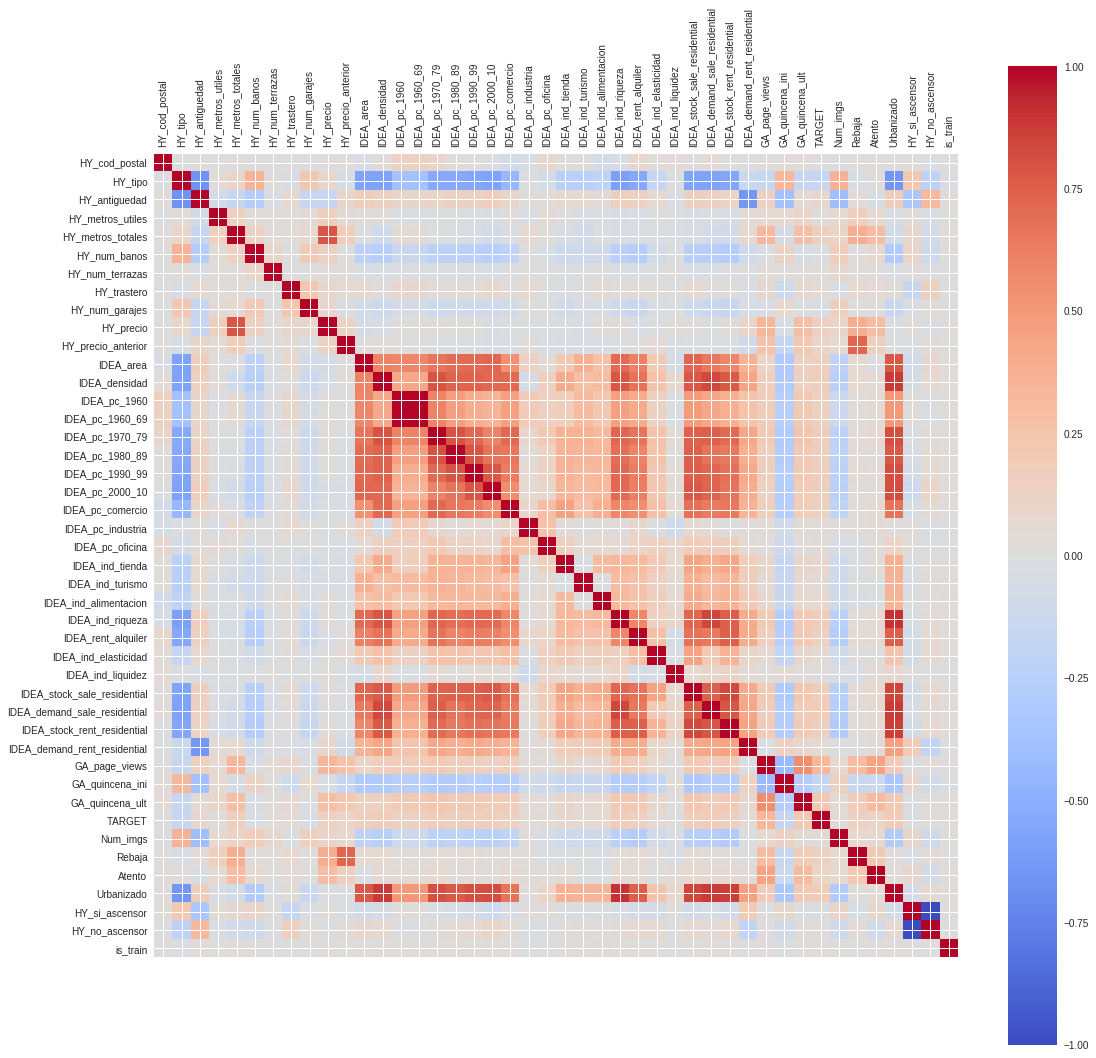

In [0]:
 plot_corr(s_df_model,18)

### Histogramas

In [0]:
#  histogramas(s_df_model)

### Boxplot

In [0]:
def boxplots(train):  
  for col in train:
    plt.boxplot(train[col], dict(markerfacecolor='g', marker='D'),showfliers=True)
    plt.title(col)
    plt.xlabel("Valores")
    plt.ylabel("Frecuencia")
    plt.show()

In [0]:
#boxplots(s_df_model)

# CLASIFICACIÓN

#### Obtenemos las categorias predictoras por un lado  y el target por otro

#### Separamos el conjunto en un conjunto de Training y un conjunto de Test

In [0]:
s_df_model["is_train"]= np.random.uniform(0,1,len(s_df_model))<=0.75

Partimos el conjunto en dos subconjuntos en función del valor -1 indicando cual era el training y el estimador

In [0]:
#s_df_model["is_train"]= s_df_model['TARGET'].values!=-1

Vemos en el histograma como se reparte los datos entre Train y test

In [0]:
# plt.hist(s_df_model.is_train)

Partimos en test y train

In [0]:
train, test = s_df_model[s_df_model["is_train"]==True],s_df_model[s_df_model["is_train"]==False]
train.drop("is_train",axis=1,inplace=True)
test.drop("is_train",axis=1,inplace=True)

In [0]:
predictors_train= no_desired_columns(train,'TARGET') 
predictors_test= no_desired_columns(test,'TARGET') 

target= train['TARGET']# hay que tener en cuenta que se empieza en el cero

### Regression Tree 

Creamos el módelo

In [0]:
# regtree= DecisionTreeRegressor(min_samples_split=5,min_samples_leaf=1,random_state=None)
# regtree.fit(predictors,target)

#### Prediction

In [0]:
#res=test
# res["regtree_preds"]= regtree.predict(predictors_test)

#train[["regtree_preds","TARGET"]]

Median absolute error

In [0]:

# mae_regtree=mean_absolute_error(np.expm1(test["TARGET"]),np.expm1(res["regtree_preds"]))    
# mae_regtree=mean_absolute_error(to_predict["TARGET"],to_predict["regtree_preds"])                    

### Regression Random Forest
    

*   n_jobs-> número de tareas en paralelo
*   obb_score-> true(aleatorio)
*   n_estimators.-> núm. de estimadores que se va a tener



In [0]:
# forest= RandomForestRegressor(n_jobs=2,n_estimators=500,)
# forest.fit(predictors_train,target)

#### prediction

In [0]:
# res=test
# res["rforest_preds"]=forest.predict(predictors_test)

In [0]:
# mae_rforest=mean_absolute_error(np.expm1(test["TARGET"]),np.expm1(res["rforest_preds"]))

### Gradient Boosting Regressor

In [0]:
gradient= GradientBoostingRegressor(n_estimators=500, max_depth=5,min_samples_split=2,learning_rate=0.01)
gradient.fit(predictors_train,target)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

#### Prediction

In [0]:
res=test
res["gboost_preds"]=gradient.predict(predictors_test)

In [0]:
mae_gboost=mean_absolute_error(np.expm1(test["TARGET"]),np.expm1(res["gboost_preds"]))
# mae_gboost=mean_absolute_error(to_predict["TARGET"],to_predict["gboost_preds"])

# RESULTADO (SCORE)

#### MAE de los clasificadores

In [0]:
# df_res_classifiers = pd.DataFrame({'mae_rforest': [mae_rforest], 'mae_regtree': [mae_regtree],'mae_gboost':[mae_gboost]})
# df_res_classifiers = pd.DataFrame({'mae_rforest': [mae_rforest],'mae_gboost':[mae_gboost]})
mae_gboost
# df_res_classifiers
# mae_rforest

41.20504184280683

#### Fichero final

In [0]:
# test["HY_id"]=df_model["HY_id"]
# test= test[["HY_id","regtree_preds"]]
# test= test.rename(columns={"regtree_preds":"TM_Est"})
# test.to_csv(r'Minsait_UJI_Math.random()_1.txt', header=True, index=None, sep='|', mode='w')
# df=pd.read_csv('Minsait_UJI_Math.random()_1.txt', sep="|")

In [0]:
# df.head()

# df.shape